In [1]:
import os, time
import numpy as np 
import corner as DFM
from astropy.io import fits
# --- gqp_mc ---
from gqp_mc import data as Data 
# --- provabgs --- 
from provabgs import infer as Infer

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# lets read in some BGS-like photometry and spectra

In [3]:
specs, prop = Data.Spectra(sim='lgal', noise='bgs0', lib='bc03', sample='mini_mocha') 
photo, _ = Data.Photometry(sim='lgal', noise='legacy', sample='mini_mocha') 

In [4]:
prop.keys()

dict_keys(['galid', 't_lookback', 'dt', 'sfh_disk', 'sfh_bulge', 'Z_disk', 'Z_bulge', 'logM_disk', 'logM_bulge', 'logM_total', 't_age_MW', 'Z_MW', 'redshift', 'cosi', 'tau_ism', 'tau_bc', 'vd_disk', 'vd_bulge', 'logM_fiber', 'airmass', 'moon_alt', 'moon_ill', 'moon_sep', 'seeing', 'sun_alt', 'sun_sep', 'texp_total', 'transp', 'wave_sky', 'sbright_sky', 'sfr_1gyr', 'sfr_100myr'])

In [5]:
igal = 2
z = prop['redshift'][igal]
mstar = prop['logM_total'][igal]

(-1.0, 5.0)

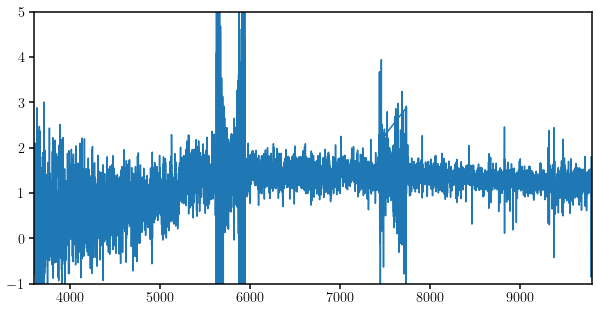

In [6]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(specs['wave'], specs['flux'][igal])
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylim(-1., 5.)

# set up the model, flux_calib, and prior

In [7]:
priors = Infer.load_priors([
        Infer.UniformPrior(8, 12, label='sed'),
        Infer.FlatDirichletPrior(4, label='sed'), 
        Infer.UniformPrior(np.array([6.9e-5, 6.9e-5, 0., 0., -2.2]), np.array([7.3e-3, 7.3e-3, 3., 4., 0.4]), label='sed')
    ])

In [8]:
desi_mcmc = Infer.desiMCMC(prior=priors)

In [9]:
t0 = time.time()
zeus_chain = desi_mcmc.run(
    photo_obs=photo['flux'][igal,:3], 
    photo_ivar_obs=photo['ivar'][igal,:3],
    zred=z, 
    bands='desi',
    sampler='zeus',
    nwalkers=100, 
    burnin=100,
    opt_maxiter=2000,
    niter=1000, 
    debug=True)
print('%f sec' % (time.time() - t0))

--- initializing the walkers ---


/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1520: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  integrand = integrand[values_slice]
Initialising ensemble of 100 walkers...


initial theta = [10.735867301971854, 0.8362036661992753, 0.39410275629492214, 0.7290167257316538, 0.29973102245396954, 0.004790171092141889, 0.004287467360571963, 1.3803595081925712, 0.26794747287967774, -1.1001554710890382]
--- burn-in ---


Sampling progress : 100%|██████████| 100/100 [03:42<00:00,  2.22s/it]
Initialising ensemble of 100 walkers...


--- running main MCMC ---


Sampling progress : 100%|██████████| 1000/1000 [34:13<00:00,  2.05s/it]

Speculator.sed: redshift = 0.309752
Speculator.sed: tage = 10.179947
Speculator.sed: theta [ 1.07147056e+01  2.82804239e-01  3.81273881e-01  1.27816153e-01
  2.08105727e-01  3.94633340e-03  4.31399720e-03  1.56946204e+00
  4.19001961e-01 -5.35072595e-01  1.01799468e+01]
Speculator.sed: log(ssp lum) [-10.99457063 -11.00158144 -11.0856355  ...  -9.89021521  -9.90245022
  -9.90697686]
2279.864669 sec


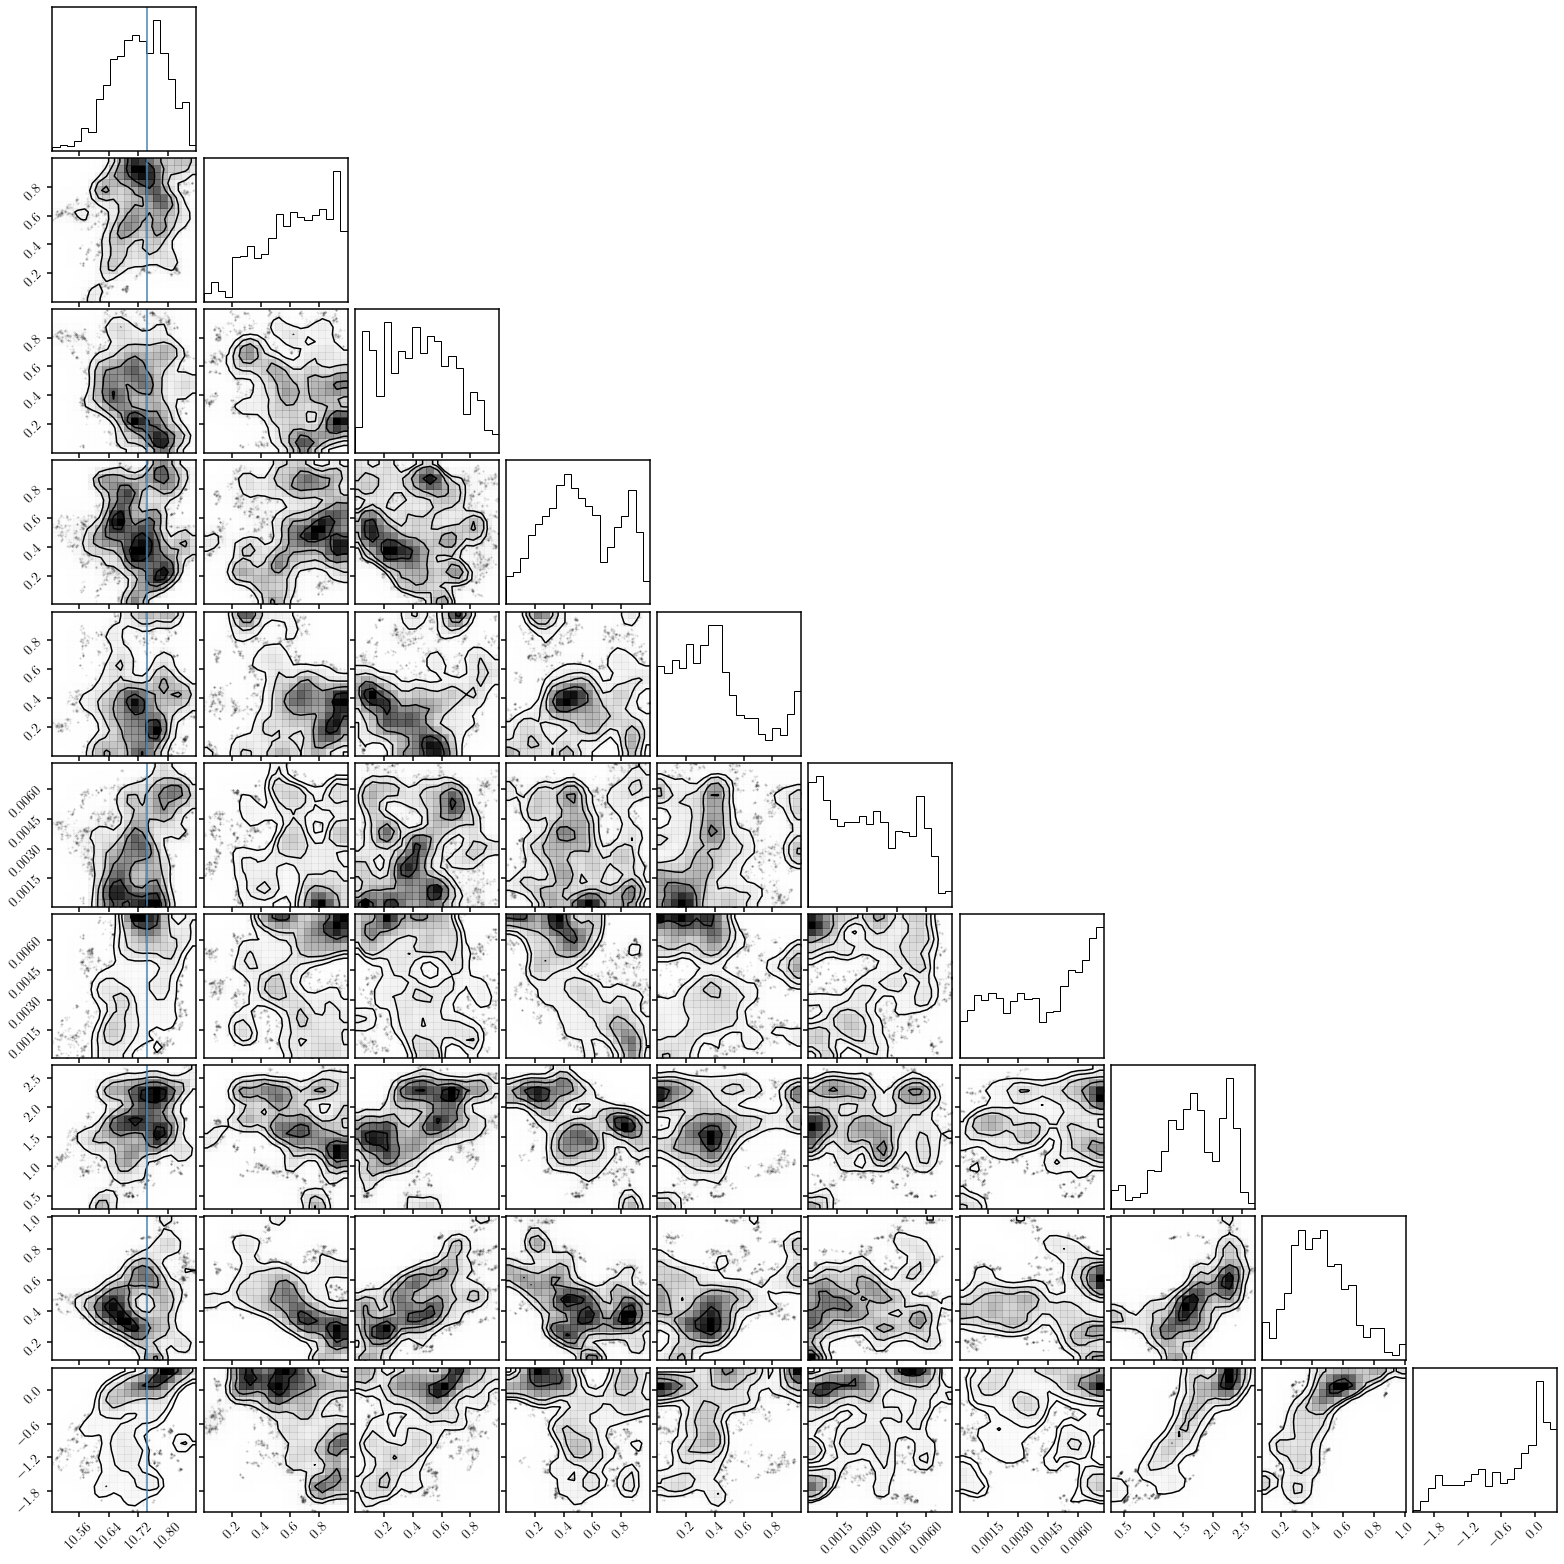

In [10]:
flat_chain = desi_mcmc._flatten_chain(zeus_chain['mcmc_chain'])
_ = DFM.corner(flat_chain[::10], smooth=1, truths=[mstar, None, None, None, None, None, None, None, None, None, None])

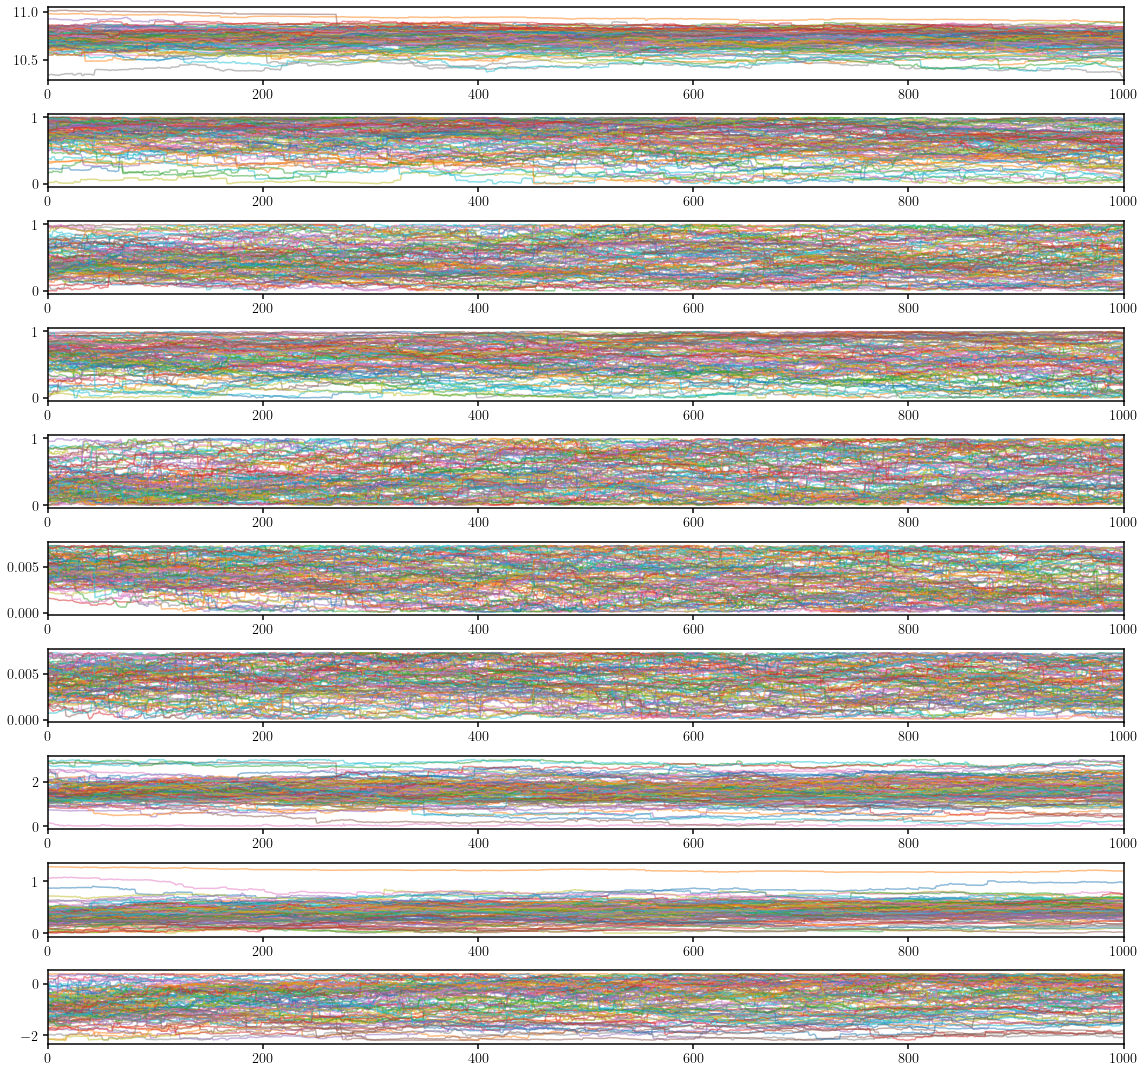

In [11]:
plt.figure(figsize=(16,15))
for n in range(10):
    plt.subplot2grid((10, 1), (n, 0))
    plt.plot(zeus_chain['mcmc_chain'][:,:,n], alpha=0.5)
    plt.xlim(0, 1000)
plt.tight_layout()
plt.show()

In [ ]:
t0 = time.time()
emcee_chain = desi_mcmc.run(
    wave_obs=specs['wave'], 
    flux_obs=specs['flux'][igal], 
    flux_ivar_obs=specs['ivar'][igal],
    zred=z, 
    mask='emline', 
    sampler='emcee',
    nwalkers=100, 
    niter='adaptive', 
    debug=True)
print('%f sec' % (time.time() - t0))

flat_chain = desi_mcmc._flatten_chain(emcee_chain['mcmc_chain'])
_ = DFM.corner(flat_chain[::10], truths=[mstar, None, None, None, None, None, None, None, None, None, None])

In [12]:
t0 = time.time()
zeus_chain = desi_mcmc.run(
    wave_obs=specs['wave'], 
    flux_obs=specs['flux'][igal], 
    flux_ivar_obs=specs['ivar'][igal],
    zred=z, 
    mask='emline', 
    sampler='zeus',
    nwalkers=100, 
    niter=1000, 
    debug=True)
print('%f sec' % (time.time() - t0))

--- initializing the walkers ---


Initialising ensemble of 100 walkers...
Sampling progress :   0%|          | 0/1000 [00:00<?, ?it/s]

initial theta = [10.596397387553289, 0.5982685057368804, 0.5957082853060605, 0.33954775595151787, 0.543145176620931, 0.004344639200662529, 0.00473212293293703, 1.4619197991539226, 1.714382780967322, -0.9762311117946019]


Sampling progress : 100%|██████████| 1000/1000 [12:06<00:00,  1.38it/s]

Speculator.sed: redshift = 0.309752
Speculator.sed: tage = 10.179947
Speculator.sed: theta [ 1.02311309e+01  3.97258166e-01  3.68332014e-01  1.26888294e-01
  1.07521527e-01  1.70929760e-03  2.31331792e-03  1.32412313e+00
  4.02605786e-01 -8.65143680e-01  1.01799468e+01]
Speculator.sed: log(ssp lum) [-10.93983249 -10.92760068 -10.97359103 ...  -9.71718526  -9.72669887
  -9.72969361]
727.173375 sec


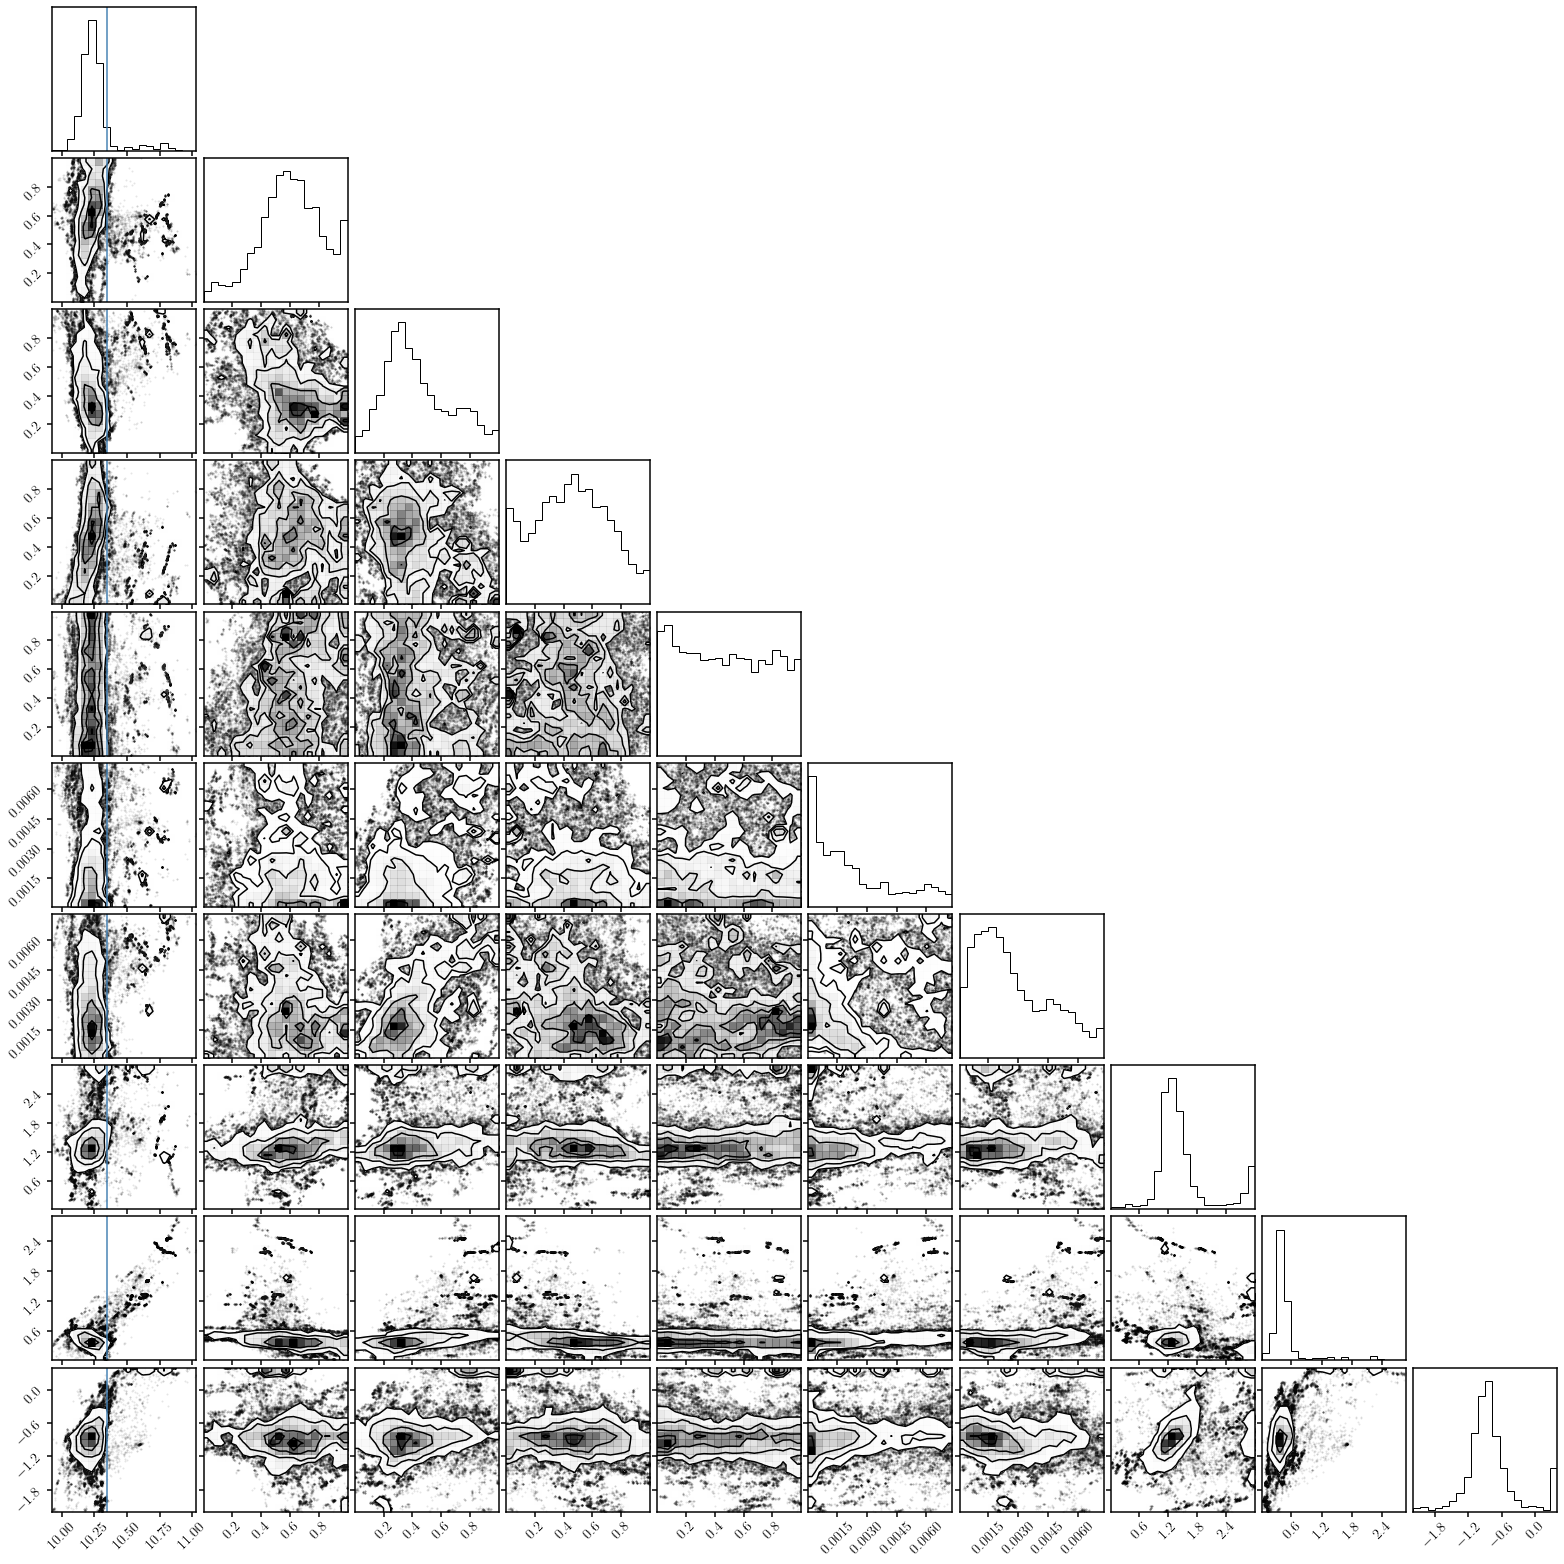

In [13]:
flat_chain = desi_mcmc._flatten_chain(zeus_chain['mcmc_chain'])
_ = DFM.corner(flat_chain, truths=[mstar, None, None, None, None, None, None, None, None, None])

(-1.0, 5.0)

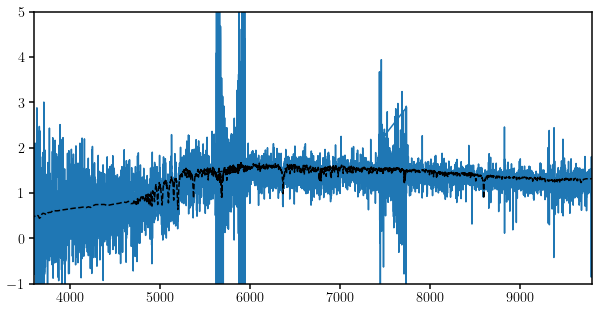

In [14]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(specs['wave'], specs['flux'][igal])
sub.plot(specs['wave'], zeus_chain['flux_spec_model'], c='k', ls='--')
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylim(-1., 5.)